In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import os
import time
import copy
import collections
import torch

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

In [0]:
root_path = 'gdrive/My Drive/Colab Notebooks/'
dataset_dir = 'car_data/'
dataset_path = os.path.join(root_path, dataset_dir)
class_name_filename = 'names.csv'

train_dir = os.path.join(dataset_path,'train')
test_dir = os.path.join(dataset_path,'test')
class_names_path = os.path.join(root_path, class_name_filename)

classes_df = pd.read_csv(class_names_path)
class_names = classes_df.label.values.tolist()

In [0]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Total Number of Samples: 1630
Number of Samples in Train: 819
Number of Samples in Test: 811
Number of Classes: 20
 Sizes of Datasets:  811 819


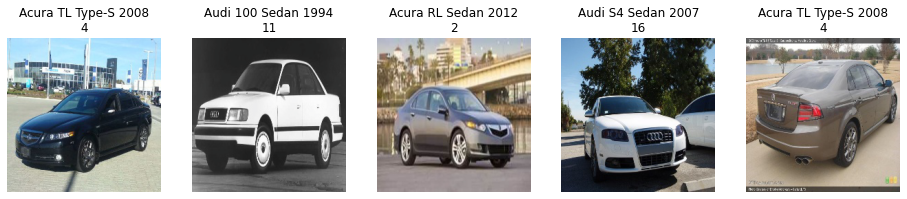

In [10]:
data_transforms = {
    'train': transforms.Compose([
                # transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.RandomRotation(0.10),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

batch_size=32
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['val'])

# Loading datasets into dataloader 
dataloaders = {'train': DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=8),
               'val': DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=8)}

dataset_sizes = {'train': len(train_dataset),
                 'val': len(test_dataset)}

print("Total Number of Samples: {}".format(len(train_dataset) + len(test_dataset)))
print("Number of Samples in Train: {}".format(len(train_dataset)))
print("Number of Samples in Test: {}".format(len(test_dataset)))
print("Number of Classes: {}".format(len(train_dataset.classes)))

## Method to display Image for Tensor
def imshow(image, ax=None, title=None, normalize=True):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

print(" Sizes of Datasets: ", len(test_dataset), len(train_dataset))

# Displaying Training Images
images, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(figsize=(16, 5), ncols=5)
for ii in range(5):
    index_class = labels[ii].item()
    ax = axes[ii]
    ax.set_title("{}\n{}".format(class_names[index_class], index_class))
    
    imshow(images[ii], ax=ax, normalize=True)
    
plt.show()

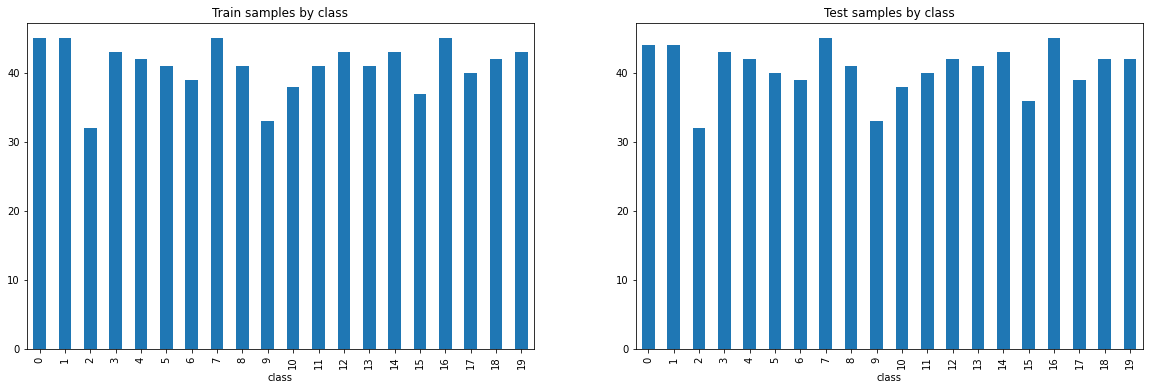

In [11]:
train_samples_df = pd.DataFrame(train_dataset.samples, columns=["image", "class"])
test_samples_df = pd.DataFrame(test_dataset.samples, columns=["image", "class"])


fig = plt.figure(figsize=(20, 6))

ax1 = fig.add_subplot(121)
train_samples_df.groupby("class").size().plot(kind="bar", ax=ax1, title="Train samples by class")

ax2 = fig.add_subplot(122)
test_samples_df.groupby("class").size().plot(kind="bar", ax=ax2, title="Test samples by class")

In [0]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, 
                                                       epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, 
                                                        time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, best_acc

In [0]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted:{class_names[preds[j]]}\nreal:{class_names[labels[j]]}')
                imshow(inputs.cpu().data[j])
                plt.show()

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        
        model.train(mode=was_training)

## ResNet34


In [15]:
import torchvision.models as models
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

model_ft = models.resnet34(pretrained=True)
# Frezee model weights
for param in model_ft.parameters():
    param.requires_grad = False

print(model_ft)
# Set the last layer to our class number
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, len(class_names))

print(model_ft)
# Only train the weights of last layer
total_params = sum(p.numel() for p in model_ft.parameters())
print('Total parameters {total_params}')
total_trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print('Total trainable parameters {total_trainable_params}')
print('Device {device}')

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# optimizer_conv = optim.SGD(model_ft.fc.parameters(), lr=0.01, momentum=0.9)
optimizer_conv = optim.Adam(model_ft.fc.parameters(), lr=0.0025, weight_decay=5e-4)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=4, gamma=0.2)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [16]:
model_conv, resnet_best_acc = train_model(model_ft, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 3.0104 Acc: 0.1331
val Loss: 2.5377 Acc: 0.2330
Epoch 1/24
----------
train Loss: 2.1002 Acc: 0.4054
val Loss: 2.0561 Acc: 0.3921
Epoch 2/24
----------
train Loss: 1.6668 Acc: 0.5299
val Loss: 1.9320 Acc: 0.4303
Epoch 3/24
----------
train Loss: 1.3776 Acc: 0.6252
val Loss: 1.7599 Acc: 0.4439
Epoch 4/24
----------
train Loss: 1.1704 Acc: 0.7241
val Loss: 1.6563 Acc: 0.4797
Epoch 5/24
----------
train Loss: 1.1231 Acc: 0.7485
val Loss: 1.6421 Acc: 0.4895
Epoch 6/24
----------
train Loss: 1.1062 Acc: 0.7399
val Loss: 1.6245 Acc: 0.4957
Epoch 7/24
----------
train Loss: 1.0471 Acc: 0.7607
val Loss: 1.6149 Acc: 0.5043
Epoch 8/24
----------
train Loss: 1.0328 Acc: 0.7741
val Loss: 1.6032 Acc: 0.5080
Epoch 9/24
----------
train Loss: 1.0104 Acc: 0.7924
val Loss: 1.6039 Acc: 0.5129
Epoch 10/24
----------
train Loss: 1.0068 Acc: 0.7912
val Loss: 1.6025 Acc: 0.5129
Epoch 11/24
----------
train Loss: 0.9876 Acc: 0.8120
val Loss: 1.5979 Acc: 0.5006
Epoch 12/24
--

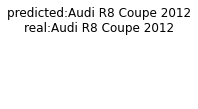

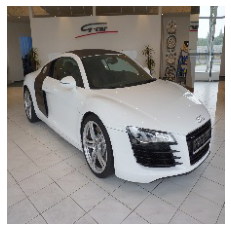

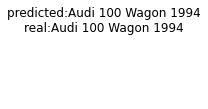

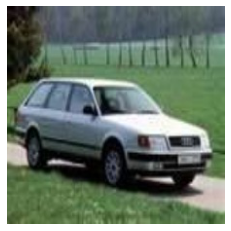

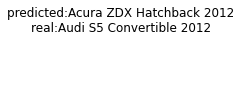

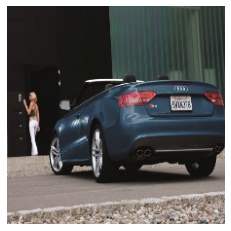

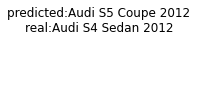

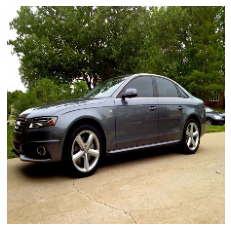

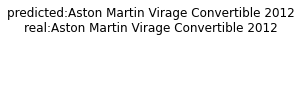

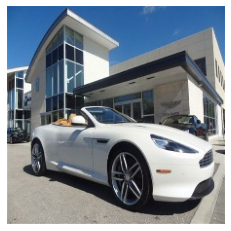

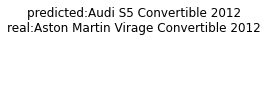

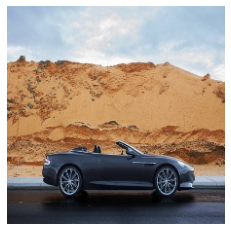

In [18]:
visualize_model(model_conv)

## AlexNet

In [19]:
model_ft = models.alexnet(pretrained=True)

for param in model_ft.parameters():
    param.requires_grad = False

print(model_ft)
# Set last layer
num_ftrs = model_ft.classifier[6].in_features
model_ft.classifier[6] = nn.Linear(num_ftrs, len(class_names))

print(model_ft)

total_params = sum(p.numel() for p in model_ft.parameters())
print(f'total parameters {total_params}')
total_trainable_params = sum(p.numel() for p in model_ft.parameters() if p.requires_grad)
print(f'total trainable parameters {total_trainable_params}')
print(f'Device {device}')

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

optimizer_conv = optim.SGD(model_ft.classifier[6].parameters(), lr=0.01, momentum=0.9)
# optimizer_conv = optim.Adam(model_ft.classifier[6].parameters(), lr=0.001, weight_decay=0.0005)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=4, gamma=0.1)

Downloading: "https://download.pytorch.org/models/alexnet-owt-4df8aa71.pth" to /root/.cache/torch/checkpoints/alexnet-owt-4df8aa71.pth



AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)


In [20]:
model_conv, alexnet_best_acc = train_model(model_ft, criterion, optimizer_conv, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 5.8787 Acc: 0.2259
val Loss: 7.3194 Acc: 0.2602
Epoch 1/24
----------
train Loss: 5.7335 Acc: 0.4151
val Loss: 7.2899 Acc: 0.3021
Epoch 2/24
----------
train Loss: 4.5913 Acc: 0.4835
val Loss: 6.9660 Acc: 0.3403
Epoch 3/24
----------
train Loss: 3.4425 Acc: 0.5946
val Loss: 7.2559 Acc: 0.3305
Epoch 4/24
----------
train Loss: 2.0306 Acc: 0.6764
val Loss: 5.8936 Acc: 0.3662
Epoch 5/24
----------
train Loss: 1.4679 Acc: 0.7204
val Loss: 5.4853 Acc: 0.3970
Epoch 6/24
----------
train Loss: 1.2240 Acc: 0.7558
val Loss: 5.3439 Acc: 0.3637
Epoch 7/24
----------
train Loss: 1.1606 Acc: 0.7631
val Loss: 5.1761 Acc: 0.3847
Epoch 8/24
----------
train Loss: 0.9865 Acc: 0.7912
val Loss: 5.1276 Acc: 0.3884
Epoch 9/24
----------
train Loss: 0.9609 Acc: 0.7741
val Loss: 5.0846 Acc: 0.3884
Epoch 10/24
----------
train Loss: 0.8650 Acc: 0.8107
val Loss: 5.0524 Acc: 0.3909
Epoch 11/24
----------
train Loss: 0.8543 Acc: 0.8046
val Loss: 5.0342 Acc: 0.3884
Epoch 12/24
--

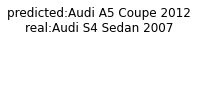

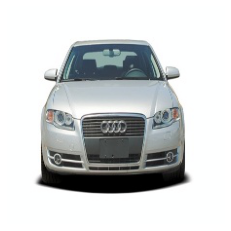

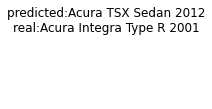

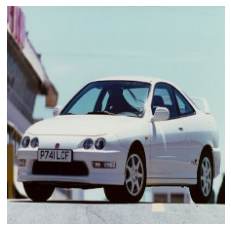

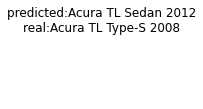

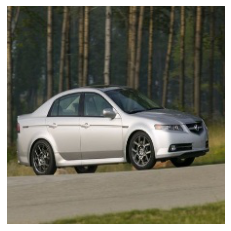

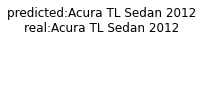

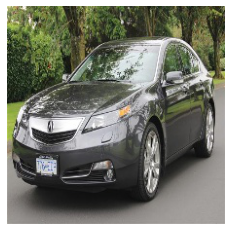

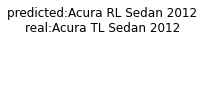

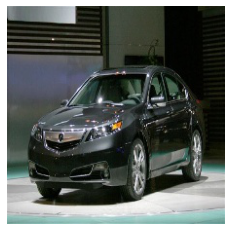

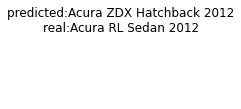

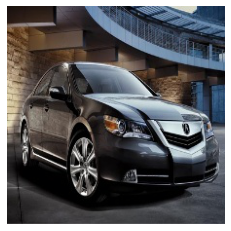

In [21]:
visualize_model(model_conv)